## False Coloring Introduction 


#### Purpose
Render grayscale digital pathology datasets into virtual H&E color space for 3D pathology. This notebook is used to describe some of the main features of the FalseColor python package, and view the results. The main processing application of this package is color_script.py located in the scripts folder. 

#### Using this notebook

##### CPU processing
1. A dataset from the Examples/h5_sample_data folder is loaded into a DataObject class for parallel processing
2. A runnable dictionary is created which contains a 'runnable' (method) fc.falseColor, and 'kwargs' (None in this case) which will be passed to the DataObjects processImages method. The purpose of this is to have an object which possesses abstracted processing method which could apply any user-defined image processing operation in a generalized form.
3. The data is false colored using the falseColor method from Color.py

##### GPU processing
With GPU processing there are a few more pre processing steps that occur, which happen implicitly in the CPU version.
NOTE: for using the non-flat field based fc.rapidFalseColor method additional background subtraction is unneeded.
1. Background levels are calculated and subtracted from both channels and image levels are clipped to the range of 0-65535.
2. Edges are enhanced using the sharpenImage method in Color.py
3. The flat field for each channel is calculated and resized 
4. The images are false colored using the rapidFalseColor method from Color.py

In [1]:
import FalseColor.Color as fc
from FalseColor.FCdataobject import DataObject
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
from FalseColor.Process import ViewImage
import h5py as h5
import scipy.ndimage as nd
import skimage as sk
import cv2
import copy

## CPU Processing

In [2]:
#load data in ./h5_sample_data/example_data.h5
file_path = os.path.join(os.getcwd(),'h5_sample_data/prostate')

#setup DataObject with hdf5 imageSet
Dataset = DataObject(file_path)
Dataset.setupH5data()
Dataset.imageSet.shape

(2, 16, 1024, 1024)

In [3]:
#create runnable for CPU processing
runnable_dict = {'runnable':fc.falseColor,'kwargs': None}

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x21f5def0208>)

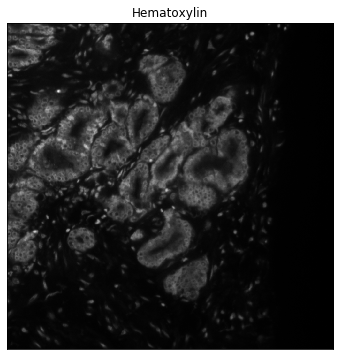

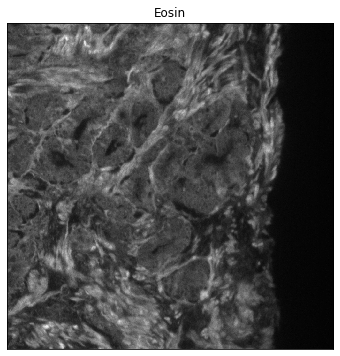

In [4]:
#view raw data
ViewImage(Dataset.imageSet[0,0,:,:], title = 'Hematoxylin', cmap = 'gray', figsize = (8,6))
ViewImage(Dataset.imageSet[1,0,:,:], title = 'Eosin', cmap = 'gray', figsize = (8,6))

In [5]:
#run parallel processing on multiple CPU cores
pseudo_colored_data = Dataset.processImages(runnable_dict,np.asarray([Dataset.imageSet[0], Dataset.imageSet[1]]))

TypeError: Cannot cast ufunc subtract output from dtype('float64') to dtype('int16') with casting rule 'same_kind'

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d640c0df60>)

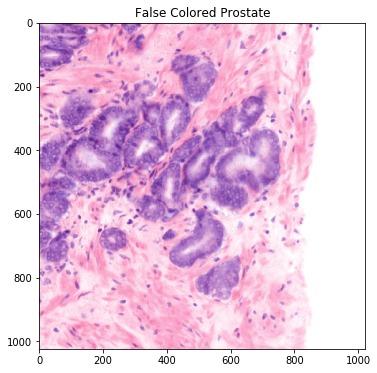

In [7]:
#View results
ViewImage(pseudo_colored_data[0,0],title='False Colored Prostate',figsize=(6,6))

In [8]:
#Separate data into Hematoxylin (nuclei), and Eosin (cyto) 3D arrays
#This is just because the data is already in memory
nuclei = copy.deepcopy(Dataset.imageSet[:,:,:,0]).astype(float)
cyto = copy.deepcopy(Dataset.imageSet[:,:,:,1]).astype(float)
nuclei.shape

(16, 1024, 1024)

## GPU Processing

In [9]:
#Preprocessing

#Background subtraction and sharpening
nuc_bg = fc.getBackgroundLevels(nuclei[-1])[1]
cyto_bg = fc.getBackgroundLevels(cyto[-1])[1]

#subtract background
nuclei_nobackground = copy.deepcopy(nuclei) - nuc_bg
nuclei_nobackground = np.clip(nuclei_nobackground,0,65535)

cyto_nobackground = copy.deepcopy(cyto) - 1.0*cyto_bg
cyto_nobackground = np.clip(cyto_nobackground,0,65535)

sharp_nuclei = np.zeros(nuclei_nobackground.shape)
sharp_cyto = np.zeros(cyto_nobackground.shape)

for i in range(len(nuclei_nobackground)):
    sharp_nuclei[i] = fc.sharpenImage(nuclei_nobackground[i])
    sharp_cyto[i] = fc.sharpenImage(cyto_nobackground[i])

In [10]:
#Calculate flat field
nuc_flatfield = fc.getFlatField(sharp_nuclei)[0]
cyto_flatfield = fc.getFlatField(sharp_cyto)[0]
print(nuc_flatfield.shape)

(1, 64, 64)


In [11]:
#reshape flat field so they are the same size as image
nuc_flatfield = nd.interpolation.zoom(nuc_flatfield[0], 16, order = 1, mode = 'nearest')
cyto_flatfield = nd.interpolation.zoom(cyto_flatfield[0], 16, order = 1, mode = 'nearest')
print(nuc_flatfield.shape)

(1024, 1024)


In [12]:
#get RGB settings
settings_dict = fc.getDefaultRGBSettings()
nuclei_RGBsettings = settings_dict['nuclei']
cyto_RGBsettings = settings_dict['cyto']

In [13]:
#execute GPU accelerated false coloring on two individual images using standard background subtraction
original_settings = fc.rapidFalseColor(sharp_nuclei[0], sharp_cyto[0],
                                       nuclei_RGBsettings, cyto_RGBsettings,
                                       run_FlatField_nuc = True, run_FlatField_cyto = True
                                       cyto_normfactor = 3*cyto_flatfield,
                                       nuc_normfactor = 0.5*nuc_flatfield
                                       )

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d610a9e7f0>)

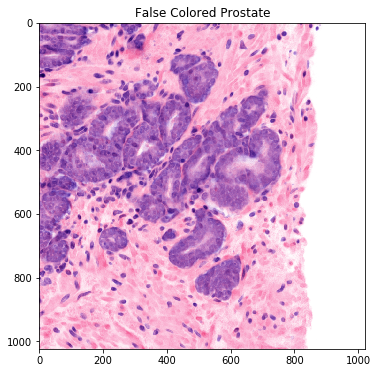

In [14]:
ViewImage(original_settings,figsize=(6,6),title='False Colored Prostate')